# Рекомендация фильмов в KION. Двухуровневая модель.

Требовалось доработать двухуровневую модель для рекомендации фильмов. Модель была улучшена следуюзим образом:
- Добавление модели ALS как дополнительной модели первого уровня;
- Подбор гиперпараметров для моделей первого и второго уровня;
- Добавление текстовых признаков в модель второго уровня.

## Методология
- Датасет разбивался на обучающую, валидационную и тестовую выборки так, чтобы в валидационной выборке было наибольшее число пользователей из обучающей выборки.
- В качестве моделей первого уровня использовались модели AlternatingLeastSquares и BayesianPersonalizedRanking. В качестве моделей второго уровня использовался CatBoostClassifier.
- Гиперпараметры подбирались с использованием алгоритма [RandomSearch](https://academy.yandex.ru/handbook/ml/article/podbor-giperparametrov#random-search), реализованный в библиотеке hyperopt. Для моделей первого уровня гиперпараметры подбирались по метрике precision@30, а для модели второго уровня по метрике RocAucScore.

## Результаты

Результаты модели из лекции:
- precision@20 = 0.044762059725303775
- recall@20 = 0.04471552891491657
- mrr@20 = 0.021779298353482298

Результаты с одной моделью первого уровня (BPR):
- precision@20 = 0.06864896996550587
- recall@20 = 0.06861303048169069
- mrr@20 = 0.048816243611167806

Результаты с одной моделью первого уровня (ALS):
- precision@20 = 0.0779669070263317
- recall@20 = 0.07792818862536736
- mrr@20 = 0.05504763223008938

Результаты с двумя моделями первого уровня:
- precision@20 = 0.08196958876571027
- recall@20 = 0.08192536785101918
- mrr@20 = 0.058161889080957874

## Выводы
1. При подборе гиперпараметров и добавлении текстовых признаков все метрики увеличились более чем в 1.5 раза.
2. Как модель первого уровня, модель ALS показала себя лучше, чем модель BPR, что отразилось как на промежуточных метриках на валидации, так и на итоговых метриках на тесте.
3. Наилучшие результаты были получены со всеми доработками. По сравнению с первичной версией модели, все метрики увеличились примерно в 2 раза. 

In [1]:
import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sparse
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from typing import Tuple

from catboost import CatBoostClassifier, Pool
import implicit

In [2]:
random_state = 42
k = 30
model_1lvl = 'BOTH' # ALS, BPR or BOTH

# Загрузка данных

In [3]:
# !unzip "data_kion.zip"

In [4]:
interactions = pd.read_csv("data_kion/interactions_df.csv")
items = pd.read_csv("data_kion/items.csv")
users = pd.read_csv("data_kion/users.csv")

In [5]:
print("Процент пропусков")
round(interactions.isna().sum() / interactions.shape[0] * 100, 3)

Процент пропусков


user_id          0.000
item_id          0.000
last_watch_dt    0.000
total_dur        0.000
watched_pct      0.015
dtype: float64

Пропусков мало, уберём их

In [6]:
interactions.dropna(inplace=True)

# EDA

In [7]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions.sort_values(by='last_watch_dt', inplace=True)
print(f"Количество данных: {interactions.shape}")
interactions.head()

Количество данных: (5475423, 5)


user_id  item_id last_watch_dt  total_dur  watched_pct
3547322   310745    13373    2021-03-13       4485         98.0
4413690   952323    15997    2021-03-13       7507        100.0
1914778   889459    11460    2021-03-13         60          0.0
4874017   854016    11237    2021-03-13       5381         98.0
4005920   307257     9132    2021-03-13       5814        100.0

Отделим просмотры, которые длятся мало

total_dur
count   5475423.00
mean       8295.49
std       48570.74
min           1.00
25%         372.00
50%        2898.00
75%        7116.00
max    80411672.00

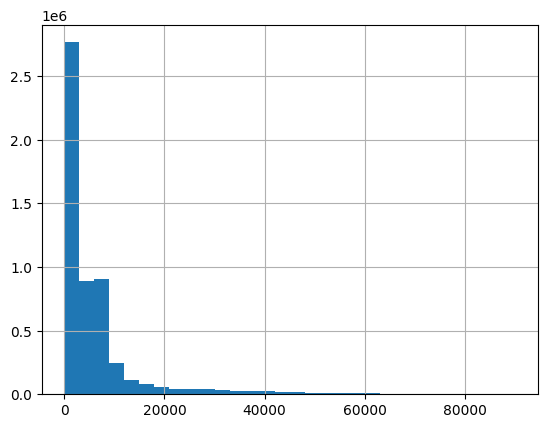

In [8]:
display(round(interactions[['total_dur']].describe(), 2))
interactions[interactions['total_dur'] < interactions['total_dur'].quantile(0.99)]['total_dur'].hist(bins=30);

In [9]:
interactions = interactions[interactions['total_dur'] >= interactions['total_dur'].quantile(0.25)]
print(interactions.shape)
interactions.head()

(4106591, 5)


user_id  item_id last_watch_dt  total_dur  watched_pct
3547322   310745    13373    2021-03-13       4485         98.0
4413690   952323    15997    2021-03-13       7507        100.0
4874017   854016    11237    2021-03-13       5381         98.0
4005920   307257     9132    2021-03-13       5814        100.0
4413604   372891     1572    2021-03-13       6617         93.0

In [10]:
interactions[interactions['user_id'] == 735886]

user_id  item_id last_watch_dt  total_dur  watched_pct
3224846   735886     9935    2021-03-13        974         15.0
639395    735886     2575    2021-03-13        819         16.0

Уберём юзеров, которые мало смотрели

In [11]:
user_interactions_count = interactions.groupby(by='user_id', as_index=False) \
                                      .agg(items_cnt=('item_id', 'count'))
print(user_interactions_count.shape)
user_interactions_count.head()

(801714, 2)


user_id  items_cnt
0        0          1
1        1          2
2        2         45
3        3         25
4        4          1

items_cnt
count  801714.00
mean        5.12
std         9.13
min         1.00
50%         2.00
75%         5.00
85%         9.00
95%        19.00
max       426.00

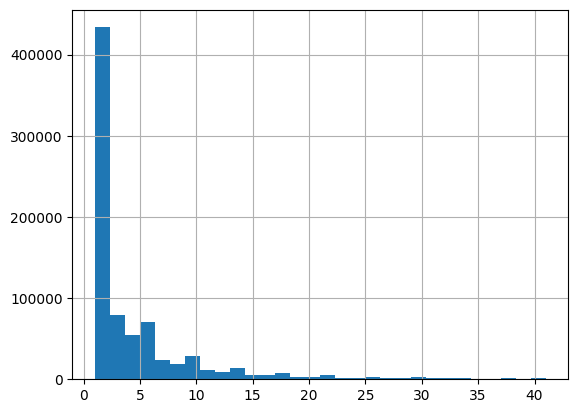

In [12]:
display(round(user_interactions_count[['items_cnt']].describe(percentiles=[0.5, 0.75, 0.85, 0.95]), 2))
user_interactions_count[
    user_interactions_count['items_cnt'] < user_interactions_count['items_cnt'].quantile(0.99)]['items_cnt'].hist(bins=30);

In [13]:
filtered_users = user_interactions_count[
    user_interactions_count['items_cnt'] >= user_interactions_count['items_cnt'].quantile(0.85)][['user_id']]
interactions = filtered_users.merge(interactions, how='left')
print(interactions.shape)
interactions.head()

(2393551, 5)


user_id  item_id last_watch_dt  total_dur  watched_pct
0        2     7571    2021-05-20       6151        100.0
1        2    11577    2021-05-21       4974         98.0
2        2    16166    2021-05-21       5980         95.0
3        2     4436    2021-05-29       2618         30.0
4        2    12965    2021-05-30       6095        100.0

Уберём фильмы, у которых мало просмотров

In [14]:
item_interactions_count = interactions.groupby(by='item_id', as_index=False) \
                                      .agg(items_cnt=('user_id', 'count'))
print(item_interactions_count.shape)
item_interactions_count.head()

(13380, 2)


item_id  items_cnt
0        0         16
1        1         14
2        2         21
3        3         10
4        4          5

items_cnt
count   13380.00
mean      178.89
std      1018.52
min         1.00
50%         9.00
60%        17.00
70%        39.00
80%       118.00
max     43793.00

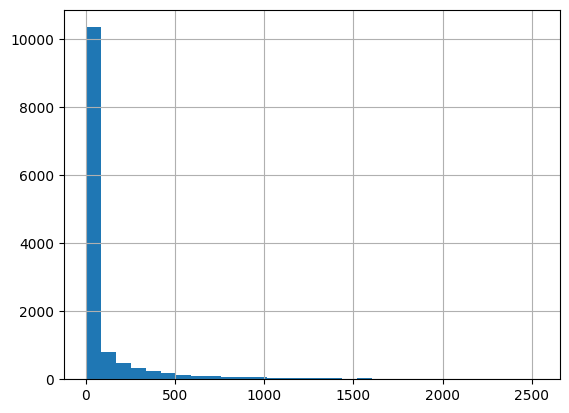

In [15]:
display(round(item_interactions_count[['items_cnt']].describe(percentiles=[0.5, 0.6, 0.7, 0.8]), 2))
item_interactions_count[
    item_interactions_count['items_cnt'] < item_interactions_count['items_cnt'].quantile(0.99)]['items_cnt'].hist(bins=30);

In [16]:
filtered_items = item_interactions_count[
    item_interactions_count['items_cnt'] >= item_interactions_count['items_cnt'].quantile(0.6)][['item_id']]
interactions = filtered_items.merge(interactions, how='left')
print(interactions.shape)
interactions.head()

(2358720, 5)


item_id  user_id last_watch_dt  total_dur  watched_pct
0        2    78224    2021-04-13       1029        100.0
1        2    88440    2021-06-28        400         85.0
2        2   132500    2021-07-09        435         92.0
3        2   307404    2021-03-16        410         87.0
4        2   435519    2021-04-01        441         93.0

# Разбиение на train и test

В выборке почти 24 недели. Возьмём в валидацию побольше данных, так как будем использовать модели 1 уровня на юзерах с просмотрами в валидационной выборке.

In [17]:
test_threshold = interactions['last_watch_dt'].max() - pd.Timedelta(weeks=1)

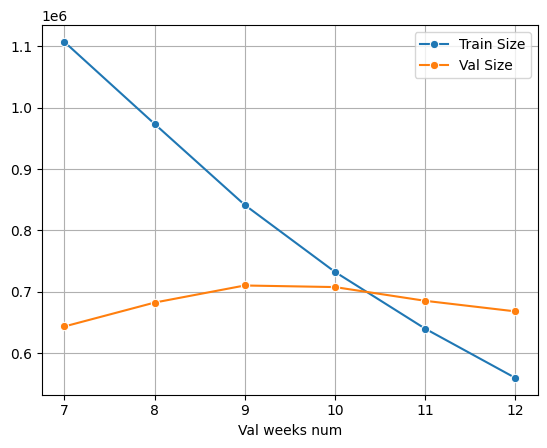

In [18]:
train_lens = []
val_lens = []
for weeks in range(7, 13):
    val_threshold = test_threshold - pd.Timedelta(weeks=weeks)
    test = interactions[interactions['last_watch_dt'] >= test_threshold]
    train_val = interactions[interactions['last_watch_dt'] < test_threshold]

    val = train_val[(train_val['last_watch_dt'] >= val_threshold)]
    train = train_val[(train_val['last_watch_dt'] < val_threshold)]

    # Будем предсказывать кандидатов только на теплых пользователях - у которых есть просмотры в обучающей выборке
    val = val[val['user_id'].isin(train['user_id'].unique())]
    
    train_lens.append(len(train))
    val_lens.append(len(val))

sns.lineplot(x=range(7, 13), y=train_lens, label="Train Size", marker='o')
sns.lineplot(x=range(7, 13), y=val_lens, label="Val Size", marker='o')
plt.grid()
plt.xlabel("Val weeks num")
plt.show()
plt.close()

In [19]:
val_threshold = test_threshold - pd.Timedelta(weeks=9)
test = interactions[interactions['last_watch_dt'] >= test_threshold]
train_val = interactions[interactions['last_watch_dt'] < test_threshold]

val = train_val[(train_val['last_watch_dt'] >= val_threshold)]
train = train_val[(train_val['last_watch_dt'] < val_threshold)]

# Будем предсказывать кандидатов только на теплых пользователях - у которых есть просмотры в обучающей выборке
val = val[val['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (841370, 5)
val: (710084, 5)
test: (178336, 5)


# Модели 1 уровня

Обучим ALS и BPR.

In [20]:
users_id = list(np.sort(train['user_id'].unique()))
items_train = list(train['item_id'].unique())
ratings_train = list(train['watched_pct'])

rows_train = train['user_id'].astype('category').cat.codes
cols_train = train['item_id'].astype('category').cat.codes

train_sparse = sparse.csr_matrix((ratings_train, (rows_train, cols_train)), shape=(len(users_id), len(items_train)))

In [21]:
def recall(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    recall_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = len(row[true_col])
      recall_values.append(num_relevant / num_true)
    return np.mean(recall_values)

def precision(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    precision_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = min(k, len(row[true_col]))
      precision_values.append(num_relevant / num_true)
    return np.mean(precision_values)

def mrr(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    mrr_values = []
    for _, row in df.iterrows():
      intersection = set(row[true_col]) & set(row[pred_col][:k])
      user_mrr = 0
      if len(intersection) > 0:
          for item in intersection:
              user_mrr = max(user_mrr, 1 / (row[pred_col].index(item) + 1))
      mrr_values.append(user_mrr)
    return np.mean(mrr_values)

def calculate_all_metrics(df: pd.DataFrame,
                          pred_col='preds',
                          true_col='item_id',
                          k=30) -> Tuple[float, float, float]:
    return (recall(df, pred_col, true_col, k),
            precision(df, pred_col, true_col, k),
            mrr(df, pred_col, true_col, k))

In [22]:
def predict(user_vecs, item_vecs, k=10):
    id2user = dict(zip(rows_train, train.user_id))
    id2item = dict(zip(cols_train, train.item_id))

    scores = user_vecs.dot(item_vecs.T)

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    preds = pd.DataFrame({
        'user_id': range(user_vecs.shape[0]),
        'preds': indices.tolist()
        })
    preds['user_id'] = preds['user_id'].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [23]:
matrix_size = train_sparse.shape[0] * train_sparse.shape[1]
num_interactions = len(train_sparse.nonzero()[0])
sparsity = 100 * (1 - (num_interactions / matrix_size))
print("Разреженность матрицы:", sparsity)

Разреженность матрицы: 99.77819482946313


ALS

In [24]:
have_als_model = 1

In [25]:
if not have_als_model:
    space = {
        'factors': hp.randint('factors', 30, 50),
        'regularization': hp.uniform('regularization', 0, 1),
        'iterations': hp.randint('iterations', 30, 80)
    }

    def handle_interrupt(trials, best_params, best_loss):
        def _handler(signum, frame):
            print('\nOptimization interrupted.')
            print('Best current parameters:', best_params)
            print('Best current loss:', best_loss)
            print('Returning current best results.')
            trials.stop()
        return _handler
    
    def objective(model_params):
        curr_model = implicit.als.AlternatingLeastSquares(**model_params, use_gpu=False, random_state=random_state)
        curr_model.fit((train_sparse).astype('double'), show_progress=False)

        user_vecs = curr_model.user_factors
        item_vecs = curr_model.item_factors
        val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
        pred = predict(user_vecs, item_vecs, k)
        pred = val_user_history.merge(pred, how='left', on='user_id')

        curr_loss = -precision(pred) # We need to minimize function

        return {'loss': curr_loss, 'status': STATUS_OK, 'params': model_params}
    
    trials = Trials()
    best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials,
                rstate=np.random.default_rng(random_state))
    print('Best hyperparameters:', best)

    als = implicit.als.AlternatingLeastSquares(**best, use_gpu=False, random_state=random_state)
    als.fit((train_sparse).astype('double'))

    als.save('models/als.npz')
else:
    als = implicit.als.AlternatingLeastSquares().load('models/als.npz')

user_vecs = als.user_factors
item_vecs = als.item_factors
val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
pred_als = predict(user_vecs, item_vecs, k)
pred_als = val_user_history.merge(pred_als, how='left', on='user_id')
metrics = calculate_all_metrics(pred_als)
print(f"ALS recall: {metrics[0]}")
print(f"ALS precision: {metrics[1]}")
print(f"ALS mrr: {metrics[2]}")

/Users/imushkin/Library/Caches/pypoetry/virtualenvs/recsys-AEgarHFw-py3.11/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


ALS recall: 0.16398569142495042
ALS precision: 0.16563458067026257
ALS mrr: 0.09534146865577753


In [26]:
have_bpr_model = 1

In [27]:
if not have_bpr_model:
    space = {
        'factors': hp.randint('factors', 30, 50),
        'regularization': hp.uniform('regularization', 0, 1),
        'iterations': hp.randint('iterations', 30, 80)
    }

    def handle_interrupt(trials, best_params, best_loss):
        def _handler(signum, frame):
            print('\nOptimization interrupted.')
            print('Best current parameters:', best_params)
            print('Best current loss:', best_loss)
            print('Returning current best results.')
            trials.stop()
        return _handler
    
    def objective(model_params):
        curr_model = implicit.bpr.BayesianPersonalizedRanking(**model_params, use_gpu=False, random_state=random_state)
        curr_model.fit((train_sparse).astype('double'), show_progress=False)

        user_vecs = curr_model.user_factors
        item_vecs = curr_model.item_factors
        val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
        pred = predict(user_vecs, item_vecs, k)
        pred = val_user_history.merge(pred, how='left', on='user_id')

        curr_loss = -precision(pred) # We need to minimize function

        return {'loss': curr_loss, 'status': STATUS_OK, 'params': model_params}
    
    trials = Trials()
    best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials,
                rstate=np.random.default_rng(random_state))
    print('Best hyperparameters:', best)

    bpr = implicit.bpr.BayesianPersonalizedRanking(**best, use_gpu=False, random_state=random_state)
    bpr.fit((train_sparse).astype('double'))

    bpr.save('models/bpr.npz')
else:
    bpr = implicit.bpr.BayesianPersonalizedRanking().load('models/bpr.npz')

user_vecs = bpr.user_factors
item_vecs = bpr.item_factors
val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
pred_bpr = predict(user_vecs, item_vecs, k)
pred_bpr = val_user_history.merge(pred_bpr, how='left', on='user_id')
metrics = calculate_all_metrics(pred_bpr)
print(f"BPR recall: {metrics[0]}")
print(f"BPR precision: {metrics[1]}")
print(f"BPR mrr: {metrics[2]}")

BPR recall: 0.1267036749626961
BPR precision: 0.1278413015282905
BPR mrr: 0.06489225066279074


Совмещаем признаки из ALS и BRP

In [28]:
if model_1lvl == 'ALS':
    candidates = pred_als[['user_id', 'preds']]
    candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
    candidates['rank_als'] = candidates.groupby('user_id').cumcount() + 1
elif model_1lvl == 'BPR':
    candidates = pred_bpr[['user_id', 'preds']]
    candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
    candidates['rank_bpr'] = candidates.groupby('user_id').cumcount() + 1
else:
    candidates = pred_als[['user_id', 'preds']]
    candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
    candidates['rank_als'] = candidates.groupby('user_id').cumcount() + 1

    user_vecs = bpr.user_factors
    item_vecs = bpr.item_factors
    val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
    pred_bpr = predict(user_vecs, item_vecs, k * 50)
    pred_bpr = val_user_history.merge(pred_bpr, how='left', on='user_id')
    candidates_bpr = pred_bpr[['user_id', 'preds']]
    candidates_bpr = candidates_bpr.explode('preds').rename(columns={'preds': 'item_id'})
    candidates_bpr['rank_bpr'] = candidates_bpr.groupby('user_id').cumcount() + 1

    candidates = candidates.merge(candidates_bpr, on=['user_id', 'item_id'], how='left')
    # Заполним пропуски в рангах brp самым большим возможным рангом
    candidates['rank_bpr'] = candidates['rank_bpr'].fillna(item_vecs.shape[0]).astype(int)

candidates.head()

user_id item_id  rank_als  rank_bpr
0        2   16270         1      1327
1        2   12743         2      1150
2        2   12841         3      1143
3        2    1785         4       598
4        2   13159         5      1375

# Модель второго уровня

In [29]:
pos = candidates.merge(val,
                       on=['user_id', 'item_id'],
                       how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(92836, 8)


user_id item_id  rank_als  rank_bpr last_watch_dt  total_dur  watched_pct  \
0        2   13159         5      1375    2021-06-14       4731         74.0   
1        2   13867         6      1434    2021-06-24       5658        100.0   
2        2    9164        27      1476    2021-06-23       6650        100.0   
3       11   15297         7      1497    2021-07-13      35141        100.0   
4       21   12995        10       549    2021-06-16      10160        100.0   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [30]:
neg = candidates.set_index(['user_id', 'item_id'])\
                .join(val.set_index(['user_id', 'item_id']))

neg = neg[neg['watched_pct'].isna()].reset_index()

pos.shape[0] / neg.shape[0]

0.04895447838875665

In [31]:
# пусть негативных семплов будет в два раза больше, чем позитивных
neg = neg.sample(frac=(pos.shape[0] / neg.shape[0] * 2), random_state=random_state)
neg['target'] = 0

neg.shape

(185672, 8)

In [32]:
ctb_train_users, ctb_test_users = train_test_split(val['user_id'].unique(),
                                                   random_state=random_state,
                                                   test_size=0.2)

In [33]:
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                   random_state=random_state,
                                                   test_size=0.1)

In [34]:
drop_col = ['last_watch_dt', 'total_dur', 'watched_pct']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
]).drop(drop_col, axis=1)
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
]).drop(drop_col, axis=1)
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
]).drop(drop_col, axis=1)
)

In [35]:
item_cols = ['item_id', 'content_type', 'title', 'release_year', 'age_rating', 'keywords']

train_feat = (ctb_train
              .merge(users, on=['user_id'], how='left')
              .merge(items[item_cols], on=['item_id'], how='left'))

eval_feat = (ctb_eval
             .merge(users, on=['user_id'], how='left')
             .merge(items[item_cols], on=['item_id'], how='left'))

In [36]:
cat_cols = ['age', 'income', 'sex', 'content_type']
text_cols = ['title', 'keywords']
cols_to_drop = ['user_id', 'item_id']
target_col = ['target']

In [37]:
train_feat['age'] = train_feat['age'].fillna('unknown')
eval_feat['age'] = eval_feat['age'].fillna('unknown')

train_feat['income'] = train_feat['income'].fillna('unknown')
eval_feat['income'] = eval_feat['income'].fillna('unknown')

train_feat['sex'] = train_feat['sex'].fillna('unknown')
eval_feat['sex'] = eval_feat['sex'].fillna('unknown')

train_feat['keywords'] = train_feat['keywords'].fillna('')
eval_feat['keywords'] = eval_feat['keywords'].fillna('')

In [38]:
X_train, y_train = train_feat.drop(cols_to_drop + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(cols_to_drop + target_col, axis=1), eval_feat[target_col]

train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols, text_features=text_cols)
eval_dataset = Pool(data=X_val, label=y_val, cat_features=cat_cols, text_features=text_cols)

In [39]:
test_feat = (ctb_test
             .merge(users, on=['user_id'], how='left')
             .merge(items[item_cols], on=['item_id'], how='left'))

test_feat['age'] = test_feat['age'].fillna('unknown')
test_feat['income'] = test_feat['income'].fillna('unknown')
test_feat['sex'] = test_feat['sex'].fillna('unknown')
test_feat['keywords'] = test_feat['keywords'].fillna('')

X_test, y_test = test_feat.drop(cols_to_drop + target_col, axis=1), test_feat['target']

In [40]:
have_ctb_model = 1

In [41]:
if not have_ctb_model:
    space = {
        'iterations': hp.randint('iterations', 500, 1500),
        'learning_rate': hp.uniform('learning_rate', 0, 1),
        'depth': hp.randint('depth', 3, 7),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1.5, 3.5),
        'min_data_in_leaf': hp.randint('min_data_in_leaf', 3, 10),
        'subsample': hp.uniform('subsample', 0.7, 0.95),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 0.95),
        'max_bin': hp.randint('max_bin', 150, 350),
        'one_hot_max_size': hp.randint('one_hot_max_size', 15, 35),
    }

    def handle_interrupt(trials, best_params, best_loss):
        def _handler(signum, frame):
            print('\nOptimization interrupted.')
            print('Best current parameters:', best_params)
            print('Best current loss:', best_loss)
            print('Returning current best results.')
            trials.stop()
        return _handler
    
    def objective(model_params):
        curr_model = CatBoostClassifier(**model_params,
                                        loss_function='Logloss',
                                        eval_metric='AUC',
                                        random_state=random_state,
                                        thread_count=-1)
        curr_model.fit(train_dataset,
                       eval_set=eval_dataset,
                       early_stopping_rounds=100,
                       verbose=0,
                       use_best_model=True,
                       plot=False)

        y_pred = curr_model.predict_proba(X_val)
        curr_loss = -roc_auc_score(y_val, y_pred[:, 1]) # We need to minimize function

        return {'loss': curr_loss, 'status': STATUS_OK, 'params': model_params}
    
    trials = Trials()
    best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials,
                rstate=np.random.default_rng(random_state))
    print('Best hyperparameters:', best)

    ctb = CatBoostClassifier(**best,
                             loss_function='Logloss',
                             eval_metric='AUC',
                             random_state=random_state,
                             thread_count=-1)
    ctb.fit(train_dataset,
            eval_set=eval_dataset,
            early_stopping_rounds=75,
            verbose=0,
            use_best_model=True,
            plot=True)

    ctb.save_model(f'models/ctb_{model_1lvl}.cbm', format='cbm')
else:
    ctb = CatBoostClassifier().load_model(f'models/ctb_{model_1lvl}.cbm')

# Метрики качества на глобальном test

In [42]:
print(f"Shape before: {test.shape}")
test = test[test['user_id'].isin(val['user_id'].unique())]
print(f"Shape after: {test.shape}")

Shape before: (178336, 5)
Shape after: (65573, 5)


### ALS

In [43]:
if model_1lvl != 'BPR':
    user_vecs = als.user_factors
    item_vecs = als.item_factors
    test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))
    pred_als = predict(user_vecs, item_vecs, k=100)
    pred_als = test_user_history.merge(pred_als, how='left', on='user_id')

    metrics = calculate_all_metrics(pred_als, k=20)
    print(f"ALS recall: {metrics[0]}")
    print(f"ALS precision: {metrics[1]}")
    print(f"ALS mrr: {metrics[2]}")

ALS recall: 0.018157818507227034
ALS precision: 0.01817839383908898
ALS mrr: 0.009065221095013594


### BPR

In [44]:
if model_1lvl != 'ALS':
    user_vecs = bpr.user_factors
    item_vecs = bpr.item_factors
    test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))
    pred_bpr = predict(user_vecs, item_vecs, k=100)
    pred_bpr = test_user_history.merge(pred_bpr, how='left', on='user_id')

    metrics = calculate_all_metrics(pred_bpr, k=20)
    print(f"BPR recall: {metrics[0]}")
    print(f"BPR precision: {metrics[1]}")
    print(f"BPR mrr: {metrics[2]}")

BPR recall: 0.013987248151338576
BPR precision: 0.01400346992446745
BPR mrr: 0.00659561632475857


### CTB

In [45]:
if model_1lvl == 'ALS':
    pred_als = pred_als[['user_id', 'preds']]
    pred_1lvl = pred_als.explode('preds').rename(columns={'preds': 'item_id'})
    pred_1lvl['rank_als'] = pred_1lvl.groupby('user_id').cumcount() + 1
elif model_1lvl == 'BPR':
    pred_bpr = pred_bpr[['user_id', 'preds']]
    pred_1lvl = pred_bpr.explode('preds').rename(columns={'preds': 'item_id'})
    pred_1lvl['rank_bpr'] = pred_1lvl.groupby('user_id').cumcount() + 1
else:
    pred_als = pred_als[['user_id', 'preds']]
    pred_als = pred_als.explode('preds').rename(columns={'preds': 'item_id'})
    pred_als['rank_als'] = pred_als.groupby('user_id').cumcount() + 1

    user_vecs = bpr.user_factors
    item_vecs = bpr.item_factors
    test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))
    pred_bpr = predict(user_vecs, item_vecs, k=1500)
    pred_bpr = test_user_history.merge(pred_bpr, how='left', on='user_id')

    pred_bpr = pred_bpr[['user_id', 'preds']]
    pred_bpr = pred_bpr.explode('preds').rename(columns={'preds': 'item_id'})
    pred_bpr['rank_bpr'] = pred_bpr.groupby('user_id').cumcount() + 1

    pred_1lvl = pred_als.merge(pred_bpr, on=['user_id', 'item_id'], how='left')
    # Заполним пропуски в рангах brp самым большим возможным рангом
    pred_1lvl['rank_bpr'] = pred_1lvl['rank_bpr'].fillna(item_vecs.shape[0]).astype(int)

pred_1lvl.head()

user_id item_id  rank_als  rank_bpr
0       21     429         1       840
1       21   10135         2      4854
2       21     608         3      4854
3       21    5508         4       424
4       21    2624         5       306

In [46]:
pred_1lvl_ctb = pred_1lvl.copy()

# фичи для теста
score_feat = (pred_1lvl_ctb
              .merge(users, on=['user_id'], how='left')
              .merge(items[item_cols], on=['item_id'], how='left'))

score_feat['age'] = score_feat['age'].fillna('unknown')
score_feat['income'] = score_feat['income'].fillna('unknown')
score_feat['sex'] = score_feat['sex'].fillna('unknown')
score_feat['keywords'] = score_feat['keywords'].fillna('')

score_feat.head()

user_id item_id  rank_als  rank_bpr        age        income sex  kids_flg  \
0       21     429         1       840  age_45_54  income_20_40   Ж       0.0   
1       21   10135         2      4854  age_45_54  income_20_40   Ж       0.0   
2       21     608         3      4854  age_45_54  income_20_40   Ж       0.0   
3       21    5508         4       424  age_45_54  income_20_40   Ж       0.0   
4       21    2624         5       306  age_45_54  income_20_40   Ж       0.0   

  content_type                                   title  release_year  \
0         film                                    Анон        2018.0   
1         film  Робинзон Крузо: Очень обитаемый остров        2016.0   
2         film                                Вампирши        2011.0   
3         film                          Мадам парфюмер        2019.0   
4         film                                 Царство        2019.0   

   age_rating                                           keywords  
0        16.0  детектив, антиутопия, серийный убийца, конфиде...  
1         6.0  кот, остров, попугай, издевательство, антропом...  
2        16.0  вампир, любовь, 2011, соединенные штаты, вампирши  
3        12.0                     2019, франция, мадам, парфюмер  
4        16.0  драка на мечах, король, битва, Историческое со...

In [47]:
ctb_prediction = ctb.predict_proba(score_feat.drop(cols_to_drop, axis=1, errors='ignore'))

pred_1lvl_ctb['ctb_pred'] = ctb_prediction[:, 1]
pred_1lvl_ctb.head(3)

user_id item_id  rank_als  rank_bpr  ctb_pred
0       21     429         1       840  0.096111
1       21   10135         2      4854  0.070730
2       21     608         3      4854  0.133738

Проставляем итоговый ранк двухэтапной модели

In [48]:
pred_1lvl_ctb = pred_1lvl_ctb.sort_values(by=['user_id', 'ctb_pred'], ascending=[True, False])
pred_1lvl_ctb['rank_ctb'] = pred_1lvl_ctb.groupby('user_id').cumcount() + 1
pred_1lvl_ctb.head(3)

user_id item_id  rank_als  rank_bpr  ctb_pred  rank_ctb
95       21   13865        96       562  0.686364         1
45       21   14470        46      1019  0.501831         2
79       21   12995        80       549  0.448912         3

In [49]:
true_items = test.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index()
pred_items = pred_1lvl_ctb.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index().rename(columns={'item_id': 'preds'})
true_pred_items = true_items.merge(pred_items, how='left')

Итоговые метрики

In [50]:
metrics = calculate_all_metrics(true_pred_items, k=20)
print(f"CTB recall: {metrics[0]}")
print(f"CTB precision: {metrics[1]}")
print(f"CTB mrr: {metrics[2]}")

CTB recall: 0.08192536785101918
CTB precision: 0.08196958876571027
CTB mrr: 0.058161889080957874
